In [1]:
import torch

import pandas             as pd
import numpy              as np
import pylab              as pl

from sklearn.metrics import f1_score

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pl.rcParams.update(params)

In [104]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
class GCN_fn(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index_fn)

        return F.log_softmax(x, dim=1)    

In [55]:
classes = ['Peak','Filament','Sheet','Void']

df = pd.read_pickle('./data/TCW_topological_dataset.pkl')
idx = np.arange(len(df))
df.keys()

Index(['ID', 'X', 'Y', 'Z', 'MASS', 'ENVIRONMENT', 'ID_DELAUNAY_CONNECTIONS',
       'N_DELAUNAY_CONNECTIONS', 'DIS_DELAUNAY_CONNECTIONS',
       'AVDIS_DELAUNAY_CONNECTIONS', 'ID_DELAUNAY_FIRSTNEIGH_CONNECTIONS',
       'N_DELAUNAY_FIRSTNEIGH_CONNECTIONS', 'ID_BSK_CONNECTIONS',
       'N_BSK_CONNECTIONS', 'DIS_BSK_CONNECTIONS', 'AVDIS_BSK_CONNECTIONS',
       'ID_BSK_FIRSTNEIGH_CONNECTIONS', 'N_BSK_FIRSTNEIGH_CONNECTIONS'],
      dtype='object')

## Predictors: n_delaunay_connections, av_delaunay_connections, mass

In [79]:
predictors = np.array(df[['N_DELAUNAY_CONNECTIONS','AVDIS_DELAUNAY_CONNECTIONS','N_BSK_CONNECTIONS','AVDIS_BSK_CONNECTIONS']], dtype=float)
x = torch.tensor(predictors, dtype=torch.float)  #features

In [80]:
A = np.concatenate([ np.zeros(len(c[1:]))+i for i, c in  enumerate(df['ID_DELAUNAY_CONNECTIONS']) ]).ravel()
B = np.concatenate([ c[1:] for i, c in  enumerate(df['ID_DELAUNAY_CONNECTIONS']) ]).ravel()
edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions

/tmp/ipykernel_110570/1060415328.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions


In [81]:
target = np.array([ c for c in  df['ENVIRONMENT'] ])
y = torch.tensor(target, dtype=torch.long)  #target

In [82]:
data = Data(x=x, edge_index=edge_index, y=y, num_classes= len(np.unique(y)))

In [83]:
ii_train = idx <=len(idx)*0.7
train_mask = ii_train
test_mask  = ~ii_train
sum(train_mask), sum(test_mask)

(12575, 5388)

In [84]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lloss = []
lf1   = []

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    lloss.append(loss.cpu().data)
    f1 = f1_score(data.y[data.train_mask].cpu().detach().numpy(), out[data.train_mask].cpu().argmax(dim=1).detach().numpy(), average='weighted')
    lf1.append(f1)
    loss.backward()
    optimizer.step()
    
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')    

f1 = f1_score(data.y[data.test_mask].cpu().data, pred[data.test_mask].cpu(), average='weighted')
print(f'f1_score: {f1:.4f}')

cuda
Accuracy: 0.6279
f1_score: 0.5834


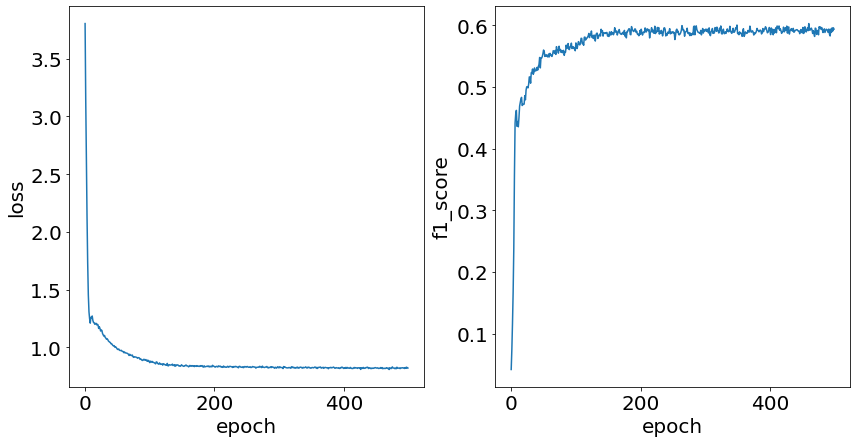

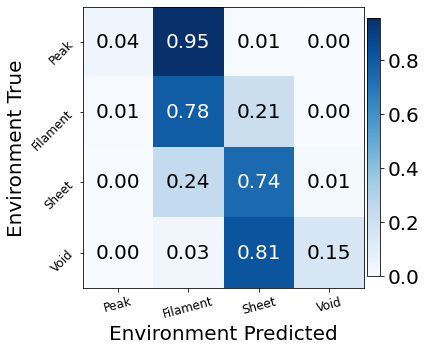

In [86]:
fig = pl.figure(figsize=(14,7))
pl.subplot(1,2,1)
_ = pl.plot(lloss)
pl.xlabel('epoch')
pl.ylabel('loss')
pl.subplot(1,2,2)
_ = pl.plot(lf1)
pl.xlabel('epoch')
pl.ylabel('f1_score')

classes = ['Peak','Filament','Sheet','Void']
#------------ Confusion Matrix
cm = confusion_matrix(np.array(data.y[data.test_mask].cpu().data), np.array(pred[data.test_mask].cpu().data))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig= pl.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(cm, interpolation='nearest', cmap=pl.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.79)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Environment Predicted",size=20)
ax.set_ylabel("Environment True",size=20)
# ax.set_ylim(4-0.5, -0.5)

pl.setp(ax.get_xticklabels(), rotation=15, size=12)
pl.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")
        
pl.show()

In [87]:
predictors = np.array(df[['N_DELAUNAY_CONNECTIONS','AVDIS_DELAUNAY_CONNECTIONS','N_BSK_CONNECTIONS','AVDIS_BSK_CONNECTIONS']], dtype=float)
x = torch.tensor(predictors, dtype=torch.float)  #features

In [88]:
A = np.concatenate([ np.zeros(len(c[1:]))+i for i, c in  enumerate(df['ID_BSK_CONNECTIONS']) ]).ravel()
B = np.concatenate([ c[1:] for i, c in  enumerate(df['ID_BSK_CONNECTIONS']) ]).ravel()
edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions

/tmp/ipykernel_110570/3411625809.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions


In [89]:
target = np.array([ c for c in  df['ENVIRONMENT'] ])
y = torch.tensor(target, dtype=torch.long)  #target

In [90]:
data = Data(x=x, edge_index=edge_index, y=y, num_classes=len(classes))

In [91]:
ii_train = idx <=len(idx)*0.7
train_mask = ii_train
test_mask  = ~ii_train
sum(train_mask), sum(test_mask)

(12575, 5388)

In [92]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lloss = []
lf1   = []

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    lloss.append(loss.cpu().data)
    f1 = f1_score(data.y[data.train_mask].cpu().detach().numpy(), out[data.train_mask].cpu().argmax(dim=1).detach().numpy(), average='weighted')
    lf1.append(f1)
    loss.backward()
    optimizer.step()
    
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')    

f1 = f1_score(data.y[data.test_mask].cpu().data, pred[data.test_mask].cpu(), average='weighted')
print(f'f1_score: {f1:.4f}')

cuda
Accuracy: 0.6316
f1_score: 0.5944


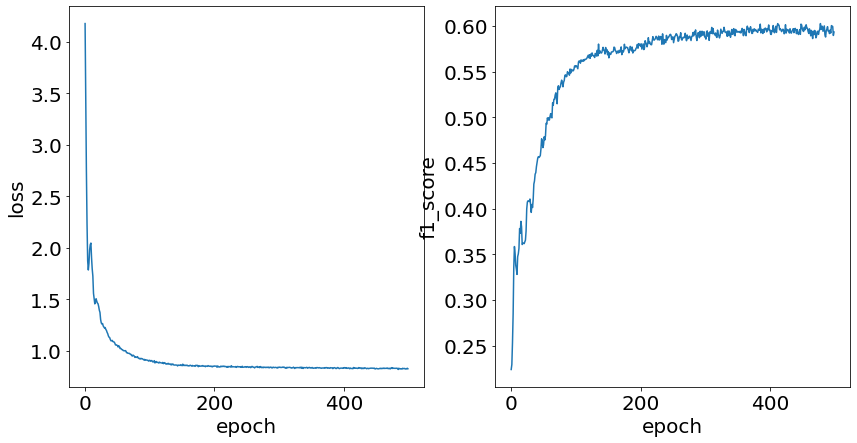

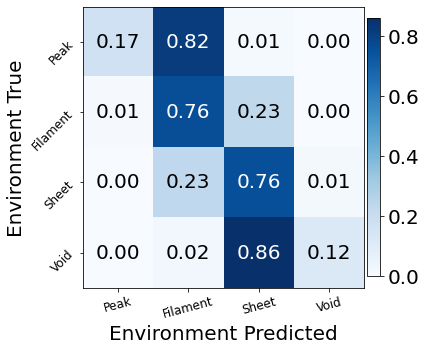

In [94]:
fig = pl.figure(figsize=(14,7))
pl.subplot(1,2,1)
_ = pl.plot(lloss)
pl.xlabel('epoch')
pl.ylabel('loss')
pl.subplot(1,2,2)
_ = pl.plot(lf1)
pl.xlabel('epoch')
pl.ylabel('f1_score')

#------------ Confusion Matrix
cm = confusion_matrix(np.array(data.y[data.test_mask].cpu().data), np.array(pred[data.test_mask].cpu().data))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig= pl.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(cm, interpolation='nearest', cmap=pl.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.79)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Environment Predicted",size=20)
ax.set_ylabel("Environment True",size=20)
# ax.set_ylim(4-0.5, -0.5)

pl.setp(ax.get_xticklabels(), rotation=15, size=12)
pl.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")
        
pl.show()